# torch.io

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchio as tio
from torch.utils.data import DataLoader

labels_df = pd.read_csv('../data/cleaned_metadata.csv')
labels_df

/home/jstabet/miniforge3/envs/dicom/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,PatientID,pCR
0,Breast_MRI_001,0
1,Breast_MRI_002,0
2,Breast_MRI_005,1
3,Breast_MRI_009,1
4,Breast_MRI_010,0
...,...,...
287,Breast_MRI_907,0
288,Breast_MRI_914,0
289,Breast_MRI_915,1
290,Breast_MRI_916,0


In [2]:
base_path = '../data/manifest-1746130313947/Duke-Breast-Cancer-MRI'

subjects = []
for i, row in labels_df.iterrows():
    pid = row['PatientID']
    label = row['pCR']

    # patient dir
    patient_path = os.path.join(base_path, pid)
    if not os.path.isdir(patient_path): continue
    assert len(os.listdir(patient_path)) == 1
    patient_path = os.path.join(patient_path, os.listdir(patient_path)[0])
    
    # t1 dir
    t1_dir = [d for d in os.listdir(patient_path) if 't1' in d.lower()]
    if not t1_dir:
        print(f'No T1 directory found for {pid}')
        continue
    assert len(t1_dir) == 1
    t1_dir = os.path.join(patient_path, t1_dir[0])

    # torch.io subjects
    subject = tio.Subject(
        mri=tio.ScalarImage(t1_dir),
        label=label
        )
    subjects.append(subject)

# Create a dataset
transform = tio.Compose([
    tio.ToCanonical(), # ensure all images are in the same orientation
    tio.Resample((1, 1, 1)), # resample to isotropic voxels
    tio.CropOrPad((512, 512, 60)), # based on median values from 0_eda.ipynb
    tio.ZNormalization(), # tio.RescaleIntensity((0, 1)),
])

dataset = tio.SubjectsDataset(subjects, transform=transform)
torch.save(dataset, '../data/preproc.pt')

No T1 directory found for Breast_MRI_552
No T1 directory found for Breast_MRI_735


269


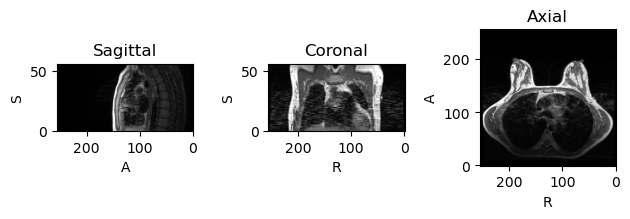

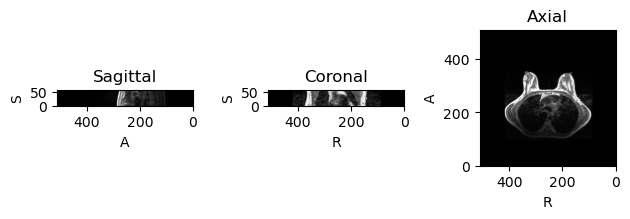

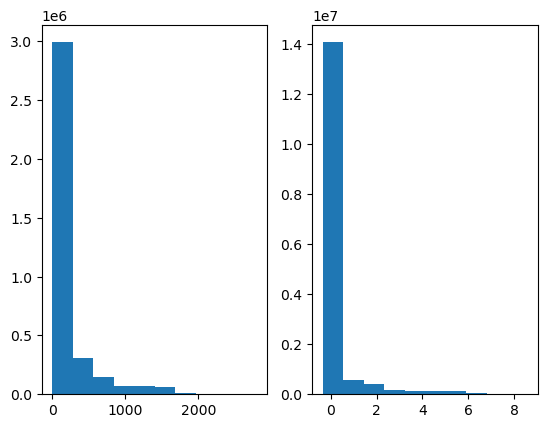

In [3]:
idx = np.random.randint(0, len(subjects))
print(idx)

subjects[idx].mri.plot()
dataset[idx].mri.plot()

plt.subplot(121)
plt.hist(subjects[idx].mri.data.flatten())
plt.subplot(122)
plt.hist(dataset[idx].mri.data.flatten())
plt.show()
# subjects[idx].mri.data.flatten().min(), subjects[idx].mri.data.flatten().max(), dataset[idx].mri.data.flatten().min(), dataset[idx].mri.data.flatten().max()

# alt: pytorch

In [4]:
import os
import pydicom
import numpy as np

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

def load_dicom_volume(t1_dir):
    slices = []
    for file in sorted(os.listdir(t1_dir)):
        dcm_file = pydicom.dcmread(os.path.join(t1_dir, file))
        image = dcm_file.pixel_array
        slices.append(image)
    volume = np.stack(slices, axis=0)  # shape: (D, H, W)
    return volume

def resize_slices(volume, target_size=(128, 128)):
    resized = []
    for i in range(volume.shape[0]):
        slice_tensor = torch.tensor(volume[i][None, ...], dtype=torch.float32)  # shape (1, H, W)
        slice_resized = F.interpolate(slice_tensor.unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)
        resized.append(slice_resized.squeeze(0))  # shape (1, H', W')
    return torch.cat(resized, dim=0)  # shape (D, H', W')

def normalize_depth(volume, target_depth=64):
    current_depth = volume.shape[0]
    if current_depth < target_depth:
        pad_total = target_depth - current_depth
        pad_before = pad_total // 2
        pad_after = pad_total - pad_before
        padding = (0, 0, 0, 0, pad_before, pad_after)  # pad D only
        volume = F.pad(volume.unsqueeze(0), padding, mode='constant', value=0).squeeze(0)
    elif current_depth > target_depth:
        start = (current_depth - target_depth) // 2
        volume = volume[start:start+target_depth]
    return volume  # shape: (target_depth, H, W)

class MRIVolumeDataset(Dataset):
    def __init__(self, volume_paths, labels):
        self.volume_paths = volume_paths
        self.labels = labels

    def __getitem__(self, idx):
        volume = load_dicom_volume(self.volume_paths[idx])
        volume = resize_slices(volume, (128, 128))
        volume = normalize_depth(volume, 64)
        volume = (volume - volume.min()) / (volume.max() - volume.min())
        return volume.unsqueeze(0), torch.tensor(self.labels[idx])

    def __len__(self):
        return len(self.volume_paths)